# Decision Tree Model

In [1]:
# Importing libraries and library functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import optuna

## Data Preprocessing 

**Loading the Dataset**
* Reads the dataset from a CSV file into a pandas DataFrame

**Data Preprocessing**
* Converts statezip to integer for better processing 
* Converts any date columns to datetime objects if necessary
* Handles missing values in numeric columns by replacing them with the median of each column

**Feature Engineering**
* Calculates the age of properties based on the year built and adds it as a new feature. Assumes the dataset is up to date to 2014

**Feature Selection**
* Excludes the target variable (price) from the feature set

**Outlier Handling**
* Removes outliers for each numeric feature using the Interquartile Range (IQR) method

In [2]:
# Loading the Dataset
print("Loading the dataset")
data_path = 'data.csv'  
df = pd.read_csv(data_path)

# check
print(df.info())
print("Data loaded successfully\n")

# Data Preprocessing: Handle missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

# Data Preprocessing: Convert statezip to integer 
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]) if pd.notnull(x) else np.nan)

# Data Preprocessing: Convert date columns to datetime if necessary
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Feature Engineering: Calculating age of property
df['age'] = 2014 - df['yr_built']  

# Feature Selection
features = df.drop(['price'], axis=1).columns

# Outlier Handling
for feature in numeric_cols:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[feature] < (Q1 - 1.5 * IQR)) | (df[feature] > (Q3 + 1.5 * IQR)))]
print("Outliers removed")

Loading the dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   o

## Correlation Matrix

**Preparation**
* Drops non-numeric columns to prepare the DataFrame for correlation matrix computation

**Displays the Correlation Matrix**

Non-numeric columns dropped for correlation matrix

Displaying correlation matrix


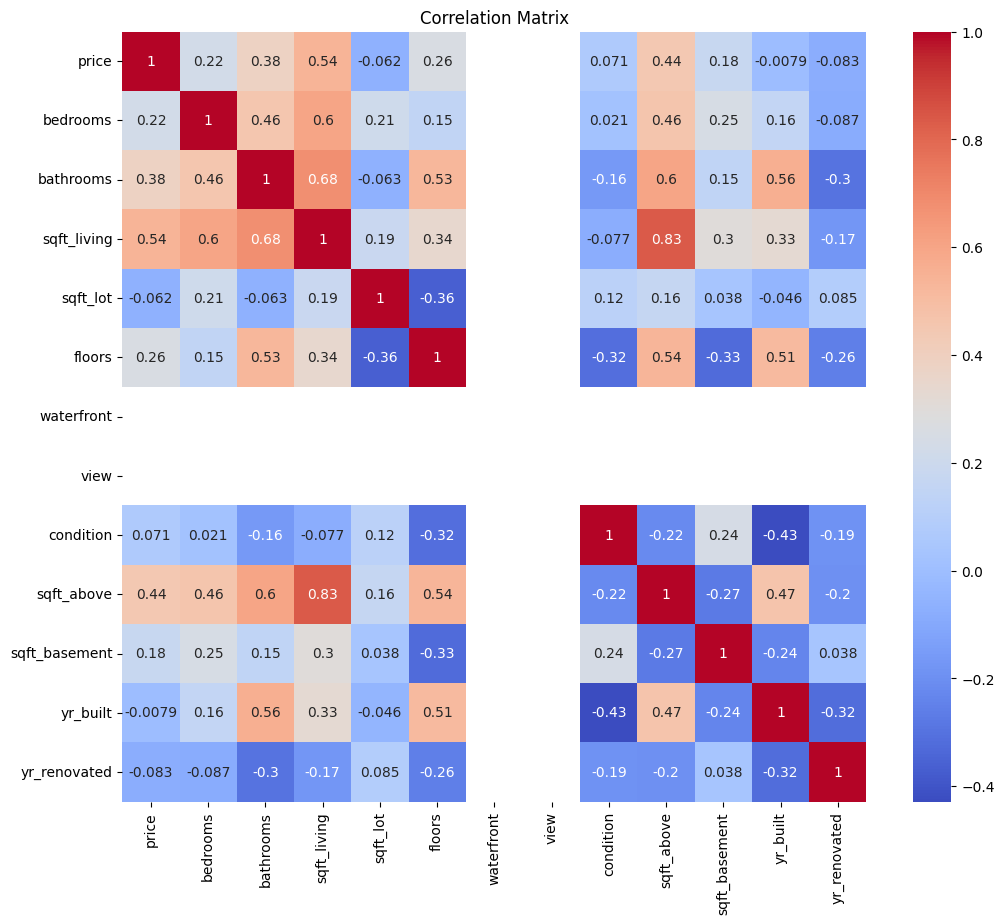

In [3]:
# Preparation: drops non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])
print("Non-numeric columns dropped for correlation matrix")

# Displays the Correlation Matrix
print("\nDisplaying correlation matrix")
plt.figure(figsize=(12, 10))
numeric_df = df[numeric_cols] 
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Continued 

**Outlier Handling**
* Re-integrate non-numeric columns 

**Feature Engineering**
* Generates polynomial features from the DataFrame 
* Appends resulting features back to the original DataFrame

**Feature Definition**
* Defines features (list of features) and target (price)

In [4]:
# Outlier Handling
df = df.loc[df_numeric.index]
print("Non-numeric columns re-integrated after outlier removal")

# Feature Engineering: Polynomial features 
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[["sqft_living", "sqft_above", "sqft_basement"]])
poly_feature_names = poly.get_feature_names_out(["sqft_living", "sqft_above", "sqft_basement"])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
df = pd.concat([df, df_poly], axis=1)

# Feature Definition
features = ["bedrooms", "bathrooms", "sqft_living", "floors", "statezip", "waterfront",
            "view", "sqft_above", "sqft_basement", "yr_renovated"] + list(poly_feature_names)
X = df[features]
y = df["price"]

Non-numeric columns re-integrated after outlier removal


## Training

**Model Training Preparation**
* Splits the data into training and test sets

**Feature Scaling**
* Creates an instance of the StandardScaler class
* Fits the scaler to the training data, then transforms data to have zero mean and unit variance

**Model Training**
* Creates an instance of the DecisionTreeRegressor class from the sklearn.tree module
* Fits model using scaled training data

In [5]:
# Model Training Preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Data split into training and test sets")

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled")

# Model Training
model = DecisionTreeRegressor(max_features=15, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Model trained & predictions made")

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

Data split into training and test sets
Features scaled
Model trained & predictions made
Cross-Validation Scores: [0.21379606 0.19078122 0.03343665 0.29113301 0.32911059]
Mean CV Score: 0.21


## Retraining (Feature Trimming & Standardization)
**Feature Trimming**
* Extract the feature importances
* Selects top features 
* Reduces training and testing data to only include the important features

**Retrains Model with trimmed features**

In [6]:
# Feature Trimming: Extract the feature importances
feature_importances = model.feature_importances_

# Feature Trimming: Select top features
threshold = 0.25
important_features = X.columns[feature_importances > threshold]

X_train_trimmed = X_train[important_features]
X_test_trimmed = X_test[important_features]
X_train_trimmed = scaler.fit_transform(X_train_trimmed)
X_test_trimmed = scaler.transform(X_test_trimmed)


# Retrains model with trimmed features
model.fit(X_train_trimmed, y_train)
y_pred_trimmed = model.predict(X_test_trimmed)
print("\nTrimmed model trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')


Trimmed model trained & predictions made
Cross-Validation Scores: [0.49405013 0.44794282 0.31305681 0.45962933 0.55555293]
Mean CV Score: 0.45


## Retraining (Hyperparameter Tuning)
**Hyperparameter tuning using GridSearchCV**
* Specifies the parameter grid
* Performs grid search with range of hyperparameters
* Retrains model

**Hyperparameter tuning using Optuna**
* Defines the objective function for Optuna, specifying the hyperparameters to be tuned and the evaluation metric (R² score)
* Optimization: optimizes the objective function over 20 trials
* Retrains model with the best parameters from the Optuna study

In [7]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [10, 12, 14, 16],
    'min_samples_split': [0.95, 2, 3],
    'min_samples_leaf': [0.9, 0.95, 1],
}

# Perform grid search with range of hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_trimmed, y_train)
print("Best Parameters:", grid_search.best_params_)

# Retrains model
best_params = grid_search.best_params_
model = DecisionTreeRegressor(max_features=15, random_state=42, **best_params)
model.fit(X_train_trimmed, y_train)
y_pred_final = model.predict(X_test_trimmed)
print("\nTuned model (GridSearchCV) trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

# Hyperparameter tuning using Optuna
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }
    
    model = DecisionTreeRegressor(max_features=15, random_state=42, **param)
    model.fit(X_train_trimmed, y_train)
    y_pred = model.predict(X_test_trimmed)
    r2 = r2_score(y_test, y_pred)
    return r2

# Optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best Parameters:", study.best_params)


# Retrains model
best_params = study.best_params
model = DecisionTreeRegressor(max_features=15, random_state=42, **best_params)
model.fit(X_train_trimmed, y_train)
y_pred_final = model.predict(X_test_trimmed)
print("\nTuned model (with Optuna) trained & predictions made")

cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

[I 2024-05-28 15:33:37,569] A new study created in memory with name: no-name-da7ec371-ac81-4710-9f58-34c52316436a
[I 2024-05-28 15:33:37,574] Trial 0 finished with value: 0.5686237284449049 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.5686237284449049.
[I 2024-05-28 15:33:37,577] Trial 1 finished with value: 0.3389382718805305 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5686237284449049.
[I 2024-05-28 15:33:37,581] Trial 2 finished with value: 0.6439110316157459 and parameters: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 13}. Best is trial 2 with value: 0.6439110316157459.
[I 2024-05-28 15:33:37,587] Trial 3 finished with value: 0.6019754193780704 and parameters: {'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 15}. Best is trial 2 with value: 0.6439110316157459.
[I 2024-05-28 15:33:37,592] Trial 4 finished with value: 0

Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 3}

Tuned model (GridSearchCV) trained & predictions made
Cross-Validation Scores: [0.52988535 0.5232729  0.36900061 0.50961615 0.61245536]
Mean CV Score: 0.51


[I 2024-05-28 15:33:37,742] Trial 17 finished with value: 0.6651458743889039 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 12}. Best is trial 14 with value: 0.6947780397447031.
[I 2024-05-28 15:33:37,752] Trial 18 finished with value: 0.574797951024866 and parameters: {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 8}. Best is trial 14 with value: 0.6947780397447031.
[I 2024-05-28 15:33:37,766] Trial 19 finished with value: 0.6303102490956036 and parameters: {'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.6947780397447031.


Best Parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 8}

Tuned model (with Optuna) trained & predictions made
Cross-Validation Scores: [0.58750118 0.58516498 0.60473878 0.55504332 0.65393531]
Mean CV Score: 0.60


## Vizualization 
* Creates scatter plot of predicted versus actual prices

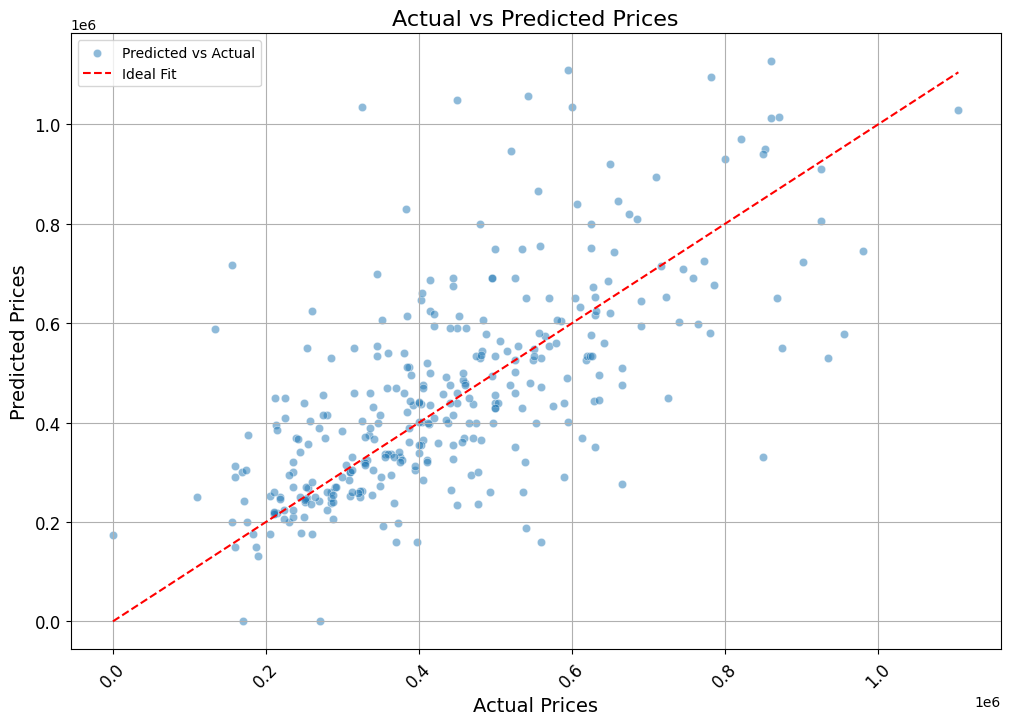

In [8]:
# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.5,
    edgecolors="w",
    linewidth=0.5,
    label="Predicted vs Actual",
)
plt.plot(
    [min(y_test), max(y_test)],
    [min(y_test), max(y_test)],
    color="red",
    linestyle="--",
    label="Ideal Fit",
)
plt.xlabel("Actual Prices", fontsize=14)
plt.ylabel("Predicted Prices", fontsize=14)
plt.title("Actual vs Predicted Prices", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Evaluation
**Evaluation Metrics**
* Mean Squared Error (MSE): calculated using mean_squared_error from scikit-learn
* R-squared: calculated using r2_score from scikit-learn
* Both metrics used to evaluate the performance of the model

**Cross-Validation**
* Cross-Validation: performed using cross_val_score to summarize the model's performance across different folds

In [9]:
# Evaluation Metrics
mse = mean_squared_error(y_test, y_pred_final)
r_squared = r2_score(y_test, y_pred_final)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Cross-Validation
cv_scores = cross_val_score(model, X_train_trimmed, y_train, cv=5)
print(f'\nCross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

Mean Squared Error: 10176208585.23
R-squared: 0.69

Cross-Validation Scores: [0.58750118 0.58516498 0.60473878 0.55504332 0.65393531]
Mean CV Score: 0.60


## Zillow's Zestimate Comparison
* Extracts last house from data for comparison

In [10]:
# Extract the last house and split the data into training and test sets
last_house = df.iloc[-1:]
x_train, _, y_train, _ = train_test_split(df[features], df['price'], test_size=0.1, random_state=42)

# Feature scaling and training model
scaler = StandardScaler()
model = DecisionTreeRegressor(max_depth=15, random_state=42)
model.fit(scaler.fit_transform(x_train), y_train)

# Predict the price for the last row and print it
predicted_price = model.predict(scaler.transform(last_house[features]))
print(f"\nPredicted price for last house: ${predicted_price[0]:,.2f}")


Predicted price for last house: $250,173.15
